# Environments information

In [1]:
!python --version

Python 3.7.13


In [2]:
!pip show numpy cvxpy

Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, xarray-einstats, wordcloud, torchvision, torchtext, tifffile, thinc, Theano-PyMC, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyerfa, pyemd, pycocotools, pyarrow, prophet, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, nibabel, netCDF4, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, Keras-Preprocessing, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, httpstan, holoviews, h5

# Problem 1


## 1-1

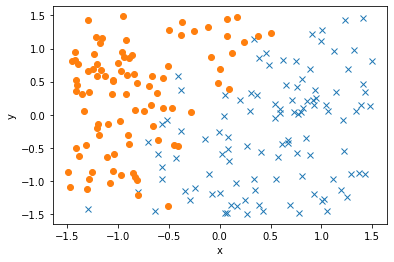

In [3]:
'''
Created on July 28, 2022

@author: ska
'''

import numpy as np
import matplotlib.pyplot as plt
#Create Toy dataset 4
np.random.seed(777)
n = 200
x_4 = 3 * (np.random.rand(n, 4) - 0.5)

y_4 = (2 * x_4[:,0] - 1 * x_4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_4 = 2 * y_4 - 1

plt.plot(np.extract(y_4>0,x_4[:,0]),np.extract(y_4>0,x_4[:,1]), 'x')
plt.plot(np.extract(y_4<0,x_4[:,0]),np.extract(y_4<0,x_4[:,1]), 'o')
plt.xlabel('x')
plt.ylabel('y')


#Adding 1 for the last of dataset's feature vector for offset
ones = np.ones((n,1))
x_4 = np.hstack([x_4, ones])
#print(x_4[0:5])

Text(0, 0.5, 'loss')

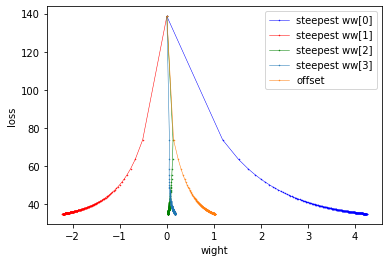

In [4]:
#Batch steepest gradient
steepest_loss= []
steepest_weight = []
dim = 4 + 1
for i in range(dim):
  weight_ = list()
  steepest_weight.append(weight_)

num_iter = 300
ww = np.full((dim,),0.)

alpha_base = 0.01

lam = 0.01
lip = 0.25 * np.amax(x_4[:,0:4]**2)


def matmul(ww, x):
    dim = ww.shape[0]
    sum=0.
    for i in range(dim):
        sum += ww[i] * x[:,i]
    return sum

x = x_4
y = y_4
for t in range(1,num_iter+1):
    post = 1 / (1 + np.exp(-y * (matmul(ww,x))))#(200,)

    grad_sum = np.sum((1-post).reshape(-1,1) * ((-y).reshape(-1,1) * x), axis=0)#(5,)

    loss = np.log(1 + np.exp(-y * (matmul(ww,x))))

   
    direction = grad_sum + 2 * lam * ww
    
    ll = np.sum(loss) + lam * (ww.T @ ww)
    for d in range(dim):
        steepest_weight[d].append(ww[d])
    steepest_loss.append(ll)
    ww = ww + alpha_base * 1.0 / np.sqrt(t) / lip * (-direction)


plt.plot(steepest_weight[0], steepest_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0]')
plt.plot(steepest_weight[1], steepest_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1]')
plt.plot(steepest_weight[2], steepest_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2]')
plt.plot(steepest_weight[3], steepest_loss, 'o-', linewidth=0.5, markersize=0.5, label='steepest ww[3]')
plt.plot(steepest_weight[4], steepest_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset')
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')

## 1-2

Text(0, 0.5, 'loss')

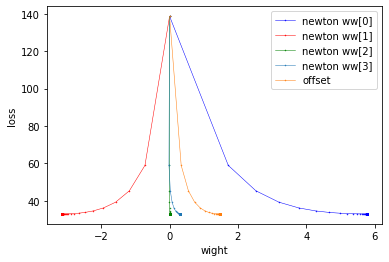

In [5]:
#Newton based
newton_weight = []
newton_loss = []

for i in range(dim):
  weight_=list()
  newton_weight.append(weight_)
  
def matmul(ww, x):
    dim = ww.shape[0]
    sum=0.
    for i in range(dim):
        sum += ww[i] * x[:,i]
    return sum

def calc_hess(x,post):
    sample_num = x.shape[0]
    sum = 0.
    for i in range(sample_num):
        post_i = post[i]
        xi = x[i].reshape(-1,1)
        sum += post_i * (1-post_i) * xi @ xi.T

    return sum


ww = np.full((dim,),0.)

alpha_base = 0.01
lam = 0.01
lip = 0.25 * np.amax(x_4[:,0:4]**2)
x = x_4
y = y_4

for t in range(1,num_iter+1):
    post = 1 / (1 + np.exp(-y * (matmul(ww,x))))#(200,)

    grad_sum = np.sum((1-post).reshape(-1,1) * ((-y).reshape(-1,1) * x), axis=0)#(5,)

    hess_sum = calc_hess(x,post)

    loss = np.log(1 + np.exp(-y * (matmul(ww,x))))

    grad = grad_sum + 2 * lam * ww
 
    hess = hess_sum + 2 * lam * np.eye(dim)
    
    ll = np.sum(loss) + lam * (ww.T @ ww)
    for d in range(dim):
      newton_weight[d].append(ww[d])
    newton_loss.append(ll)

    ww = ww - np.linalg.inv(hess)@grad * 1.0 / np.sqrt(t)


plt.plot(newton_weight[0], newton_loss, 'bo-', linewidth=0.5, markersize=0.5, label='newton ww[0]')
plt.plot(newton_weight[1], newton_loss, 'ro-', linewidth=0.5, markersize=0.5, label='newton ww[1]')
plt.plot(newton_weight[2], newton_loss, 'go-', linewidth=0.5, markersize=0.5, label='newton ww[2]')
plt.plot(newton_weight[3], newton_loss, 'o-', linewidth=0.5, markersize=0.5, label='newton ww[3]')
plt.plot(newton_weight[4], newton_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset')
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')


## 1-3

Text(0, 0.5, '$| J(\\omega^{(t)}) - J(\\hat{\\omega} ) |$')

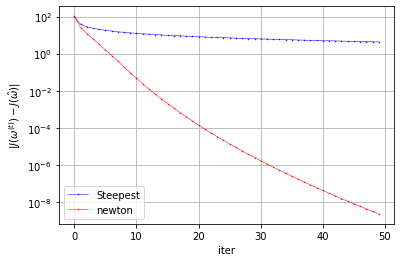

In [6]:
steepest_opt_loss = steepest_loss[-1]
newton_opt_loss = newton_loss[-1]

iter = [t for t in range(50)]
plt.plot(iter, np.abs(steepest_loss[:50] -  steepest_opt_loss), 'bo-', linewidth=0.5, markersize=0.5, label='Steepest')
plt.plot(iter, np.abs(newton_loss[:50] -  newton_opt_loss), 'ro-', linewidth=0.5, markersize=0.5, label='newton')
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel(r'$| J(\omega^{(t)}) - J(\hat{\omega} ) |$')

##1-4

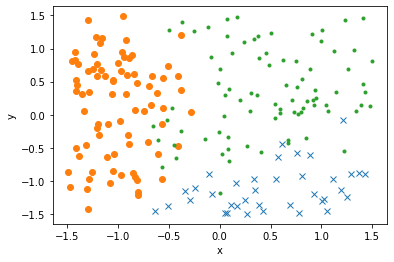

In [7]:
#Create Toy dataset 5
np.random.seed(777)
n = 200
x_5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_5 = np.argmax(np.dot(np.hstack([x_5[:,0:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

plt.plot(np.extract(y_5==0,x_5[:,0]),np.extract(y_5==0,x_5[:,1]), 'x')
plt.plot(np.extract(y_5==1,x_5[:,0]),np.extract(y_5==1,x_5[:,1]), 'o')
plt.plot(np.extract(y_5==2,x_5[:,0]),np.extract(y_5==2,x_5[:,1]), '.')
plt.xlabel('x')
plt.ylabel('y')

#Adding 1 for the last of dataset's feature vector for offset
ones = np.ones((n,1))
x_5 = np.hstack([x_5, ones])
#print(x_5[0:5])

$J(\omega) = \Sigma_{i=1}^n l(f(x_i),y_i)+λ\omega^T \omega$ \\
$l(f(x_i,y_i)) = -ln(\frac{exp(\omega_y^T x_i)}{\Sigma_{c=1}^C exp(\omega_c^T x_i)}) = -\omega_y^T x_i + ln(\Sigma_{c=1}^C exp(\omega_c^T x_i))$

###Steepest gradient

In [8]:

#Batch steepest gradient
steepest_loss= []
steepest_weight = []
class_num = 3
dim=4 + 1
#Steepest gradient

def softmax(x, wy, ww):
    sum = 0.
    for wc in ww:
        sum += np.exp(wc.T @ x)
    return np.exp(wy.T @ x) / sum

def ln_sum_exp(x,ww):
    sum = 0.
    for wc in ww:
        sum += np.exp(wc.T @ x)
    return np.log(sum)

def calc_grad(x, y, ww, class_num):
    grad = np.zeros((class_num,dim))
    for c in range(class_num):
        wc = ww[c]
        if c == y:
            grad[c] = - x + softmax(x, wc, ww)* x
        else:
            grad[c] = softmax(x,wc,ww) * x
    return grad

def matmul(ww, x):
    dim = ww.shape[0]
    sum=0.
    for i in range(dim):
        sum += ww[i] * x[:,i]
    return sum

for c in range(class_num):
  weight_ = list()
  steepest_weight.append(weight_)


num_iter = 300
alpha_base = 0.01
lam = 0.01
lip = 0.25 * np.amax(x_5[:,0:4]**2)


ww = np.full((class_num, dim),0.)


x = x_5
y = y_5
#y = np.eye(cluss_num)[y_5] #convert to one-hot-vector

for t in range(1,num_iter+1):
    w_y = ww[y]
    grad = np.zeros((class_num,dim))
    loss = 0.
    for i in range(n):
        w_yi = w_y[i]
        xi = x[i]
        yi = y[i]
        grad += calc_grad(xi, yi, ww, class_num)
        loss += - w_yi.T @ xi + ln_sum_exp(xi, ww)

    grad += 2 * lam * ww
    loss += lam * np.linalg.norm(ww,ord=2)**2
   

   
    for c in range(class_num):
        weights_c = np.copy(ww[c])
        steepest_weight[c].append(weights_c)
    steepest_loss.append(loss)

    for c in range(class_num):
        ww[c] = ww[c] + alpha_base * 1.0 / np.sqrt(t) / lip * (-grad[c])
   
steepest_weight = np.array(steepest_weight)
steepest_loss = np.array(steepest_loss)




###Plot steepest weights

Text(0, 0.5, 'loss')

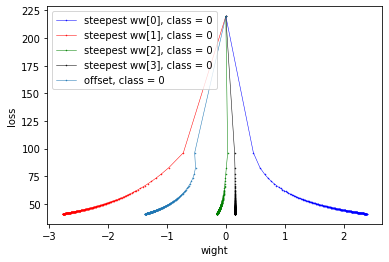

In [9]:
class_id=0
weights = steepest_weight[class_id]
plt.plot(weights[:,0], steepest_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], steepest_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], steepest_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], steepest_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], steepest_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

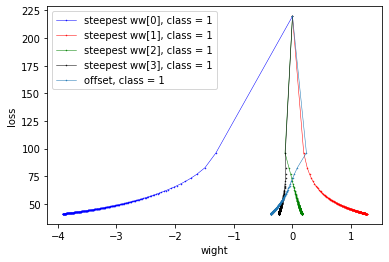

In [10]:
class_id=1
weights = steepest_weight[class_id]
plt.plot(weights[:,0], steepest_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], steepest_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], steepest_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], steepest_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], steepest_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

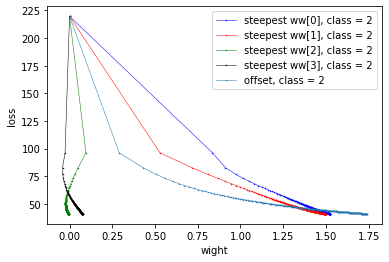

In [11]:
class_id=2
weights = steepest_weight[class_id]
plt.plot(weights[:,0], steepest_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], steepest_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], steepest_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], steepest_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], steepest_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')

###Newton

In [12]:
#Newton
newton_loss= []
newton_weight = []
class_num = 3
dim=4 + 1

def softmax(x, ww):#ok
    return np.exp(x @ ww.T) / np.sum(np.exp(x @ ww.T), axis=1).reshape(-1,1)

def calc_grad(x, y, ww, class_num):
    post = softmax(x,ww)
    #y == c -> grad[c] = (-1+post)*x
    #y != c -> grad[c] = post*x
    grad = ((post - y).T) @ x + lam * ww
    return grad

def calc_diag(post, c1, c2):
    num = post.shape[0]
    diag_ = np.empty(num)
    for i in range(num):
        diag_[i] = post[i][c1] * (np.eye(num)[c1][c2] - post[i][c2]) #calc diag values
    return np.diag(diag_)
    

def calc_hess(x, y, ww, class_num):
    num = x.shape[0]
    dim = x.shape[1]
    post = softmax(x,ww)
    #hess = np.zeros((class_num, class_num, dim, dim))
    hess = np.zeros((class_num*dim , class_num*dim))
    #i=j -> pi*(1-pi)* x@x^T
    #i!=j -> -pi*pj * x@x^T
    #Hij=x^T @ Rij @ x (Rij is diag matrix, which diag is written with 'post'.)
    for c1 in range(class_num):
        for c2 in range(class_num):
            diag = calc_diag(post, c1,c2)
            hess[c2 * dim : (c2+1)*dim, c1*dim : (c1+1)*dim] = x.T @ diag @ x
    return hess, diag


for _ in range(class_num):
  weight_ = list()
  newton_weight.append(weight_)


num_iter = 300
alpha_base = 0.01
lam = 0.01
lip = 0.25 * np.amax(x_5[:,0:4]**2)

ww = np.full((class_num, dim),0.)
x = x_5
y = np.eye(class_num)[y_5] #convert to one-hot-vector

for t in range(1, num_iter+1):
    post = softmax(x,ww)
    loss = - np.sum(y * np.log(post)) + lam  * np.linalg.norm(ww,ord=2)**2
    grad = calc_grad(x, y, ww, class_num)

    
    grad_flatten = grad.reshape(-1,1)
    hess,_ = calc_hess(x, y, ww,class_num)

    for c in range(class_num):
        weights_c = np.copy(ww[c])
        newton_weight[c].append(weights_c)
    newton_loss.append(loss)

    
    ww_flatten = ww.reshape(-1,1)
    ww_flatten = ww_flatten - np.linalg.pinv(hess) @ grad_flatten / np.sqrt(t)

    ww = ww_flatten.reshape(class_num, dim)





###Plot newton weights

Text(0, 0.5, 'loss')

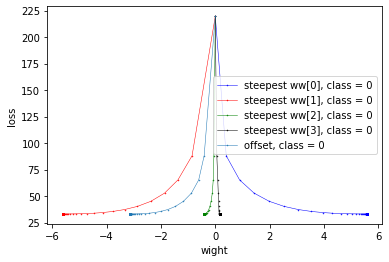

In [13]:
class_id=0
weights = np.array(newton_weight[class_id])
#print(weights[:,0])
plt.plot(weights[:,0], newton_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], newton_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], newton_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], newton_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], newton_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')



Text(0, 0.5, 'loss')

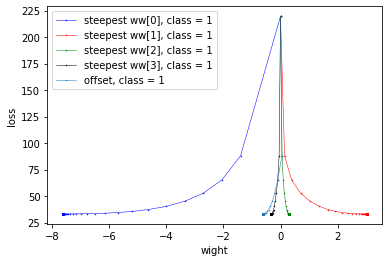

In [14]:
class_id=1
weights = np.array(newton_weight[class_id])
#print(weights[:,0])
plt.plot(weights[:,0], newton_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], newton_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], newton_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], newton_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], newton_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')


Text(0, 0.5, 'loss')

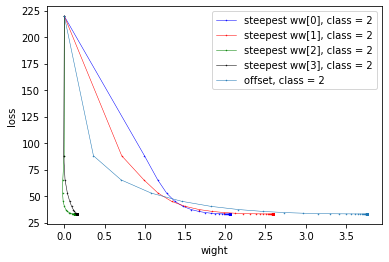

In [15]:
class_id=2
weights = np.array(newton_weight[class_id])
#print(weights[:,0])
plt.plot(weights[:,0], newton_loss, 'bo-', linewidth=0.5, markersize=0.5, label='steepest ww[0], class = {}'.format(class_id))
plt.plot(weights[:,1], newton_loss, 'ro-', linewidth=0.5, markersize=0.5, label='steepest ww[1], class = {}'.format(class_id))
plt.plot(weights[:,2], newton_loss, 'go-', linewidth=0.5, markersize=0.5, label='steepest ww[2], class = {}'.format(class_id))
plt.plot(weights[:,3], newton_loss, 'ko-', linewidth=0.5, markersize=0.5, label='steepest ww[3], class = {}'.format(class_id))
plt.plot(weights[:,4], newton_loss, 'o-', linewidth=0.5, markersize=0.5, label='offset, class = {}'.format(class_id))
plt.legend()
plt.xlabel('wight')
plt.ylabel('loss')



###Plot performance difference

Text(0, 0.5, '$| J(\\omega^{(t)}) - J(\\hat{\\omega} ) |$')

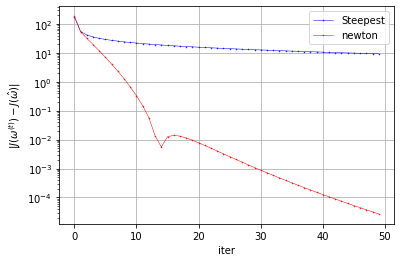

In [16]:
steepest_opt_loss = steepest_loss[-1]
newton_opt_loss = newton_loss[-1]

iter = [t for t in range(50)]
plt.plot(iter, np.abs(steepest_loss[:50] -  steepest_opt_loss), 'bo-', linewidth=0.5, markersize=0.5, label='Steepest')
plt.plot(iter, np.abs(newton_loss[:50] -  newton_opt_loss), 'ro-', linewidth=0.5, markersize=0.5, label='newton')
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel(r'$| J(\omega^{(t)}) - J(\hat{\omega} ) |$')

# Problem 2

lamda =  2 
opt =  [[0.81818182 1.09090909]]
lamda =  4 
opt =  [[0.63636364 0.18181818]]
lamda =  6 
opt =  [[0.33333333 0.        ]]


Text(0, 0.5, 'w1')

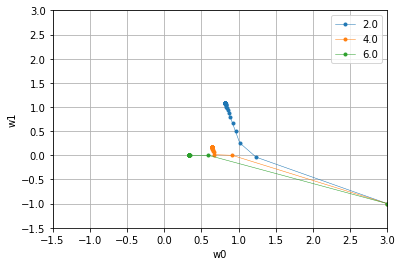

In [17]:

def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q
  return x_proj



def PG(lamda):
    A = np.array([[  3, 0.5],
                [0.5,   1]])
    mu = np.array([[1],
                [2]])
    w,v = np.linalg.eig(2*A)
    max_eig = np.max(w)
    lr = 1 / max_eig


    w_0 = np.array([[ 3],
                    [-1]])

    w_history = []
    w_t = w_0
    w_history.append(w_0.T)

    for t in range(1000):
        grad = 2 * np.dot(A, w_t-mu)
        w_th = w_t - lr * grad
        w_t = st_ops(w_th, lamda * lr)
        w_history.append(w_t.T)

    return w_history


lams = [2,4,6]
w_histories = {}
for lam in lams:
    w_histories[lam] = PG(lam)
    print("lamda = ", lam, "\nopt = ", w_histories[lam][-1])

print("==========================================")
for lam in lams:
    w_history = np.array(w_histories[lam])
    w_history = np.squeeze(w_history, 1)
    plt.plot(w_history[:,0], w_history[:,1], 'o-', markersize=3, linewidth=0.5, label = "{:.1f}".format(lam))

plt.grid()
plt.legend()
plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
plt.xlabel('w0')
plt.ylabel('w1')

In [18]:
#Verification
import cvxpy as cv

A = np.array([[  3, 0.5],
                [0.5,   1]])
mu = np.array([[1],
                [2]])
for lam in lams:
    w = cv.Variable((2,1))
    f_omega = cv.quad_form(w - mu, A) +  lam * cv.norm(w, 1)
    constraints = []

    prob = cv.Problem(cv.Minimize(f_omega),constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    print("lamda = ", lam, "\nopt = ", w.value)


lamda =  2 
opt =  [[0.8181712 ]
 [1.09085585]]
lamda =  4 
opt =  [[0.63632175]
 [0.1817989 ]]
lamda =  6 
opt =  [[ 3.32882515e-01]
 [-2.56951821e-08]]


#Problem 3

##3-3

'\nones = np.ones((n,1))\nx_4 = np.hstack([x_4, ones])\n'

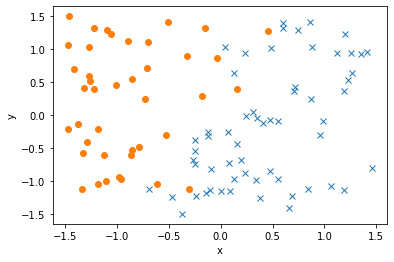

In [19]:
#Create Toy dataset 4 with dim=4
dim = 4
np.random.seed(111)
n = 100
x_4 = 3 * (np.random.rand(n, dim) - 0.5)

y_4 = (2 * x_4[:,0] - 1 * x_4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_4 = 2 * y_4 - 1

plt.plot(np.extract(y_4>0,x_4[:,0]),np.extract(y_4>0,x_4[:,1]), 'x')
plt.plot(np.extract(y_4<0,x_4[:,0]),np.extract(y_4<0,x_4[:,1]), 'o')
plt.xlabel('x')
plt.ylabel('y')
'''
ones = np.ones((n,1))
x_4 = np.hstack([x_4, ones])
'''



$||▽J(\alpha_1) - ▽J(\alpha_2) ||^2_2 <= \gamma * ||\alpha_1 - \alpha_2 ||^2_2$
⟺$||K(\alpha_1 - \alpha_2) ||^2_2 <= \gamma * ||\alpha_1 - \alpha_2 ||^2_2$  (1)

Consider eigen decomposition of $K = V \Sigma V^T $, (1) will be \\
$||K(\alpha_1 - \alpha_2) ||^2_2 <= \sigma_1||\alpha_1 - \alpha_2 ||^2_2 \space (where \space \sigma_1 \space is \space the \space largest \space eigen \space value \space of \space K)$ 

In [20]:
#dim = dim + 1
#Projection in [0,1]
def projection(alpha):
    for i in range(len(alpha)):
        a = alpha[i]
        if a > 1:
            alpha[i] = 1
        elif a < 0:
            alpha[i] = 0
        else:
            alpha[i] = a
    return alpha

def Lagrange(alpha,lamda, K):
    return - 1 / (4*lamda) * alpha.T @ K @ alpha + alpha.T @ np.ones(n)

def loss(alpha,lamda,x,y):
    num = x.shape[0]
    #print(alpha.shape, y.shape, x.shape)
    what = np.zeros(dim)
    for i in range(num):
        what += alpha[i]*y[i]*x[i]
    what = what / (2*lamda)
    sum = 0.
    for i in range(n):
        pred = 1 - y[i]*(what.T@x[i])
        sum += max(0, pred) 

    sum += lamda*(what.T @ what)
    return what, sum

lamda = 1.
alpha_0 = np.full(n,0.5)
alpha_t = alpha_0

#Initialize some vector and matrix
X = x_4
y = y_4.reshape(-1,1) * 1.
X_dash = y*X
K = X_dash @ X_dash.T
#Calculates eta 
#eta_t <= gamma^-1
#K_eig contains complex value -> Use abs value.
K_eig, _= np.linalg.eig(K)
sig_1 = np.max(np.abs(K_eig))
eta_t = 1.0 / sig_1
alpha_0 = np.full(n,1.)

num_iter = 300

eta_t = 1/ sig_1 #0.009165336325991
c = 0
while eta_t < 1.:
    c+=1
    eta_t = eta_t*10.
eta_t = eta_t -.1
while c > 0:
    c -= 1
    eta_t = eta_t / 10.

#print(eta_t)# 0.009065336325991

lag_lst = []
loss_lst = []
gap_lst = []
for i in range(num_iter):
    post_lag = Lagrange(alpha_t,lamda,K)
    
    what, hinge = loss(alpha_t, lamda, X,y)
   
    alpha_t = alpha_t - eta_t * (1 / (2*lamda) * K @ alpha_t - np.ones(n))
    alpha_t = projection(alpha_t)
    now_lag = Lagrange(alpha_t,lamda,K)
    #print(post_lag)
    #print("Hinge loss : ", hinge, "(w^ = {})".format(what))
    #print("Dual gap : ", now_lag - post_lag)

    lag_lst.append(post_lag)
    loss_lst.append(hinge)
    gap_lst.append(post_lag - hinge)



Text(0, 0.5, 'Lagrange')

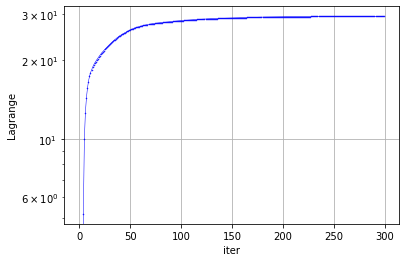

In [21]:
iter = [t for t in range(num_iter)]
plt.plot(iter, lag_lst, 'bo-', linewidth=0.5, markersize=0.5)
plt.yscale("log")
#plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel(r'Lagrange')

Text(0, 0.5, 'Total Loss')

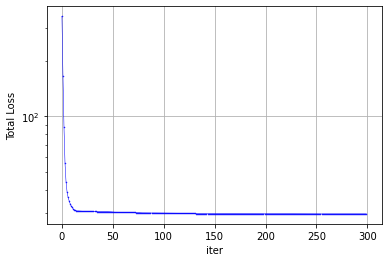

In [22]:
iter = [t for t in range(num_iter)]
plt.plot(iter, loss_lst, 'bo-', linewidth=0.5, markersize=0.5)
plt.yscale("log")
#plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel(r'Total Loss')

Text(0, 0.5, 'Duality gap ')

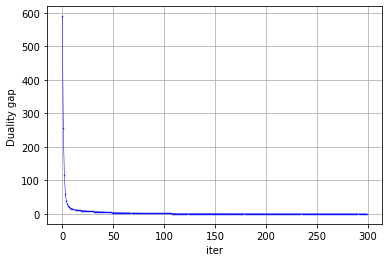

In [23]:
iter = [t for t in range(num_iter)]
plt.plot(iter, np.abs(gap_lst), 'bo-', linewidth=0.5, markersize=0.5)
#plt.yscale("log")
#plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel(r'Duality gap ')